# Twitter Sentiment and Modeling

## Overview

This project utilizes a dataset from CrowdFlower, analyzing and rating the sentiment of Twitter users regarding Apple and Google products by building an NLP model. Human raters rated the sentiment in over 9,000 Tweets as positive, negative, or neither.

## Business Problem

Apple and Google want to gather information on the consensus of their products. They are looking at Twitter as a medium to gather that information. The task is to build a model that can rate the sentiment of a Tweet based on its content.

## Data Understanding

The dataset used for this project is a csv file ("data.csv"), containing over 9,000 Tweets about Apple and Google products. Human raters rated the sentiment as positive, negative, or neither. The target column is the sentiment column.

### Import Libraries

First thing we did was import the necessary libraries for analysis, visualization, preprocessing data, and building models, as well as ignore warnings.

In [1]:
#import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import nltk
from nltk import FreqDist, ngrams
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

import string

from wordcloud import WordCloud

from collections import Counter

[nltk_data] Downloading package punkt to /Users/Chris/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Chris/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/Chris/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Data Inspection

We proceeded to load the csv dataset, then look at the shape, size, column names and data types, as well as check for missing or duplicate entries.

In [2]:
#load the dataset, ensure the proper encoding is read
df = pd.read_csv('data.csv', encoding='latin1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
#change the name of the tweet, product, and sentiment columns
df = df.rename(columns={'tweet_text': 'tweet', 'emotion_in_tweet_is_directed_at': 'brand_or_product', 'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'})
df.head()

,tweet,brand_or_product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
#look at the different values for sentiment column
df['sentiment'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64

In [5]:
#look at the 'I can't tell' rows
df.loc[df['sentiment'] == "I can't tell"].head()

,tweet,brand_or_product,sentiment
90,Thanks to @mention for publishing the news of ...,NaN,I can't tell
102,ÛÏ@mention &quot;Apple has opened a pop-up st...,NaN,I can't tell
237,Just what America needs. RT @mention Google to...,NaN,I can't tell
341,The queue at the Apple Store in Austin is FOUR...,NaN,I can't tell
368,Hope it's better than wave RT @mention Buzz is...,NaN,I can't tell


#### Drop the "I can't tell" rows 

We decided to drop the rows labeled "I can't tell", as they would only serve to confuse the dataset, and didn't make up a significant portion of the dataset anyway. 

In [6]:
#drop the I can't tell rows
mask = df['sentiment'] == "I can't tell"
df.drop(df[mask].index, inplace=True)
print(df['sentiment'].value_counts())

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
Name: sentiment, dtype: int64


#### Change Sentiment Values

We decided to combine 'I can't tell' and 'No emotion toward brand or product' into the value 'Neutral', and change
'Positive emotion' and 'Negative emotion' to just 'Positive' and 'Negative'.

In [7]:
#change sentiment values
df['sentiment'] = df['sentiment'].replace({'No emotion toward brand or product': 'Neutral',
                                           'Positive emotion': 'Positive',
                                           'Negative emotion': 'Negative'})
print(df['sentiment'].value_counts())

Neutral     5389
Positive    2978
Negative     570
Name: sentiment, dtype: int64


In [8]:
#look at the different values for brand_or_product column
df['brand_or_product'].value_counts()

iPad                               942
Apple                              659
iPad or iPhone App                 470
Google                             429
iPhone                             296
Other Google product or service    292
Android App                         81
Android                             78
Other Apple product or service      35
Name: brand_or_product, dtype: int64

In [9]:
#check information on each column
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8937 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet             8936 non-null   object
 1   brand_or_product  3282 non-null   object
 2   sentiment         8937 non-null   object
dtypes: object(3)
memory usage: 279.3+ KB


### Duplicates

We checked for and found duplicate records, then proceeded to drop them.

In [10]:
#check for duplicates
df[df.duplicated()]

,tweet,brand_or_product,sentiment
468,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive
776,Google to Launch Major New Social Network Call...,NaN,Neutral
2232,Marissa Mayer: Google Will Connect the Digital...,NaN,Neutral
2559,Counting down the days to #sxsw plus strong Ca...,Apple,Positive
3950,Really enjoying the changes in Gowalla 3.0 for...,Android App,Positive
3962,"#SXSW is just starting, #CTIA is around the co...",Android,Positive
4897,"Oh. My. God. The #SXSW app for iPad is pure, u...",iPad or iPhone App,Positive
5338,RT @mention ÷¼ GO BEYOND BORDERS! ÷_ {link} ...,NaN,Neutral
5341,"RT @mention ÷¼ Happy Woman's Day! Make love, ...",NaN,Neutral
5881,RT @mention Google to Launch Major New Social ...,NaN,Neutral


In [11]:
#check the number of duplicates
print(len(df[df.duplicated()]))

22


In [12]:
#drop duplicates
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,tweet,brand_or_product,sentiment


### Missing Values

We checked for missing values and were missing 1 value for the tweet column and almost 6,000 values for the brand_or_product column. 

In [13]:
#look at the row with the missing value for the 'tweet' column
df.loc[df['tweet'].isnull()]

,tweet,brand_or_product,sentiment
6,NaN,NaN,Neutral


#### Drop Missing Tweet 

Since there is nothing useful provided in the entire row that's the sole missing tweet, we just dropped the row.

In [14]:
#drop missing tweet row
df.dropna(subset=['tweet'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8914 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet             8914 non-null   object
 1   brand_or_product  3273 non-null   object
 2   sentiment         8914 non-null   object
dtypes: object(3)
memory usage: 278.6+ KB


Now we took a look at the missing brand/product rows.

In [15]:
#look at 20 rows of missing brand/product values
df.loc[df['brand_or_product'].isnull()].head(20)

,tweet,brand_or_product,sentiment
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,Neutral
16,Holler Gram for iPad on the iTunes App Store -...,NaN,Neutral
32,"Attn: All #SXSW frineds, @mention Register fo...",NaN,Neutral
33,Anyone at #sxsw want to sell their old iPad?,NaN,Neutral
34,Anyone at #SXSW who bought the new iPad want ...,NaN,Neutral
35,At #sxsw. Oooh. RT @mention Google to Launch ...,NaN,Neutral
37,SPIN Play - a new concept in music discovery f...,NaN,Neutral
39,VatorNews - Google And Apple Force Print Media...,NaN,Neutral
41,HootSuite - HootSuite Mobile for #SXSW ~ Updat...,NaN,Neutral
42,Hey #SXSW - How long do you think it takes us ...,NaN,Neutral


We looked for any correlation or pattern between missing brands and the sentiment. 

In [16]:
#check missing brand/product rows that have a sentiment other than Neutral
df.loc[(df['brand_or_product'].isnull()) & (df['sentiment'] != 'Neutral')]

,tweet,brand_or_product,sentiment
46,Hand-Held Û÷HoboÛª: Drafthouse launches Û÷H...,NaN,Positive
64,Again? RT @mention Line at the Apple store is ...,NaN,Negative
68,Boooo! RT @mention Flipboard is developing an ...,NaN,Negative
103,Know that &quot;dataviz&quot; translates to &q...,NaN,Negative
112,Spark for #android is up for a #teamandroid aw...,NaN,Positive
...,...,...,...
9011,apparently the line to get an iPad at the #sxs...,NaN,Positive
9043,Hey is anyone doing #sxsw signing up for the g...,NaN,Negative
9049,@mention you can buy my used iPad and I'll pic...,NaN,Positive
9052,@mention You could buy a new iPad 2 tmrw at th...,NaN,Positive


In [17]:
#print the number of missing brand/product rows that have a sentiment other than Neutral, and the number that have Neutral as the sentiment
print("Number of rows with a sentiment other than Neutral: ", len(df.loc[(df['brand_or_product'].isnull()) & (df['sentiment'] != 'Neutral')]))
print("Number of rows with Neutral as the sentiment: ", len(df.loc[(df['brand_or_product'].isnull()) & (df['sentiment'] == 'Neutral')]))

Number of rows with a sentiment other than Neutral:  357
Number of rows with Neutral as the sentiment:  5284


#### Modify Null Brand/Product Rows

With so many entries missing a value for the brand/product, and having a non-neutral sentiment, we proceed to write a function to fill in the brand/product if it contained one of our brand/product values in the tweet, then applied this function to the dataset. 

In [18]:
#function to change the brand/product column based on inclusion of one of the values in the tweet
def get_brand_or_product(tweet):
    tweet = tweet.lower()
    keywords = ['apple', 'google', 'iphone', 'ipad', 'android']
    count = 0
    brand_product = None

    for keyword in keywords:
        if keyword in tweet:
            count += 1
            brand_product = keyword
    #leave the column blank if more than one of the brand/product values is in the tweet
    if count > 1:
        brand_product = None

    return brand_product

In [19]:
#apply the function to the null rows in the dataset
mask = df['brand_or_product'].isnull()
df.loc[mask, 'brand_or_product'] = df.loc[mask, 'tweet'].apply(get_brand_or_product)
print(len(df.loc[df['brand_or_product'].isnull()]))

1492


In [20]:
#check the info on each column again
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8914 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet             8914 non-null   object
 1   brand_or_product  7422 non-null   object
 2   sentiment         8914 non-null   object
dtypes: object(3)
memory usage: 278.6+ KB


In [21]:
#look at 20 null rows again
df.loc[df['brand_or_product'].isnull()].head(20)

,tweet,brand_or_product,sentiment
39,VatorNews - Google And Apple Force Print Media...,None,Neutral
41,HootSuite - HootSuite Mobile for #SXSW ~ Updat...,None,Neutral
51,ÛÏ@mention {link} &lt;-- HELP ME FORWARD THIS...,None,Neutral
52,÷¼ WHAT? ÷_ {link} ã_ #edchat #musedchat #s...,None,Neutral
53,.@mention @mention on the location-based 'fast...,None,Neutral
66,At #sxsw? @mention / @mention wanna buy you a ...,None,Neutral
68,Boooo! RT @mention Flipboard is developing an ...,None,Negative
71,Chilcott: @mention #SXSW stand talking with Bl...,None,Neutral
73,Gowalla's @mention promises to launch Foursqua...,None,Neutral
77,I worship @mention {link} #SXSW,None,Neutral


#### Placeholder 

We decided to put a placeholder of 'Unknown' for the rest of the null rows. 

In [22]:
#fill missing rows with 'Unknown'
df['brand_or_product'].fillna('Unknown', inplace=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8914 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet             8914 non-null   object
 1   brand_or_product  8914 non-null   object
 2   sentiment         8914 non-null   object
dtypes: object(3)
memory usage: 278.6+ KB
None


In [23]:
#check values for brand_or_product again
df['brand_or_product'].value_counts()

google                             1639
Unknown                            1492
ipad                                946
iPad                                941
iphone                              684
apple                               671
Apple                               657
iPad or iPhone App                  469
Google                              427
iPhone                              295
Other Google product or service     292
android                             209
Android App                          80
Android                              77
Other Apple product or service       35
Name: brand_or_product, dtype: int64

After our work with the brand_or_product column, we proceeded to limit the values in that column for consistency with capitalization. 

In [24]:
#change brand_or_product values
df['brand_or_product'] = df['brand_or_product'].replace({'google': 'Google',
                                           'ipad': 'iPad',
                                           'iphone': 'iPhone',
                                            'apple': 'Apple',
                                            'android': 'Android'})
print(df['brand_or_product'].value_counts())

Google                             2066
iPad                               1887
Unknown                            1492
Apple                              1328
iPhone                              979
iPad or iPhone App                  469
Other Google product or service     292
Android                             286
Android App                          80
Other Apple product or service       35
Name: brand_or_product, dtype: int64


### Data Cleaning

We performed standard actions such as standardizing and tokenizing the data. 

#### Standardizing Case

We explored some tweets and decided to lowercase all text. 

In [25]:
#look at examples of tweets to inspect for spelling
print(df["tweet"].to_list()[:10])

['.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.', "@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW", '@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.', "@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw", "@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)", '@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd', '#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan', 'Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB', 'C

Given that we have instances of SXSW and sxsw that we want to treat as the same, and there presumably may be instances of different capitalizations of terms like "Apple" and "iPhone", we proceed to lowercase all tweets in our dataset.

In [26]:
# Transform tweets to lowercase
df["tweet"] = df["tweet"].str.lower()

#print example
print(df.iloc[50]["tweet"])

ûï@mention {link} &lt;-- help me forward this doc to all anonymous accounts, techies,&amp; ppl who can help us jam #libya #sxsw


#### Tokenize the Full Dataset

We proceeded to create a tokenizer pattern and test it on a sample of rows

In [27]:
#create a tokenizer pattern to avoid unnecessary separate treatment of words 
basic_token_pattern = r"(?u)\b\w\w+\b"

tokenizer = RegexpTokenizer(basic_token_pattern)

tweets = df.loc[:5, "tweet"].tolist()  # Convert the slice to a list of strings
tokenized_tweets = [tokenizer.tokenize(tweet) for tweet in tweets[:10]]  # Tokenize the first 10 tweets
print(tokenized_tweets)

[['wesley83', 'have', '3g', 'iphone', 'after', 'hrs', 'tweeting', 'at', 'rise_austin', 'it', 'was', 'dead', 'need', 'to', 'upgrade', 'plugin', 'stations', 'at', 'sxsw'], ['jessedee', 'know', 'about', 'fludapp', 'awesome', 'ipad', 'iphone', 'app', 'that', 'you', 'll', 'likely', 'appreciate', 'for', 'its', 'design', 'also', 'they', 're', 'giving', 'free', 'ts', 'at', 'sxsw'], ['swonderlin', 'can', 'not', 'wait', 'for', 'ipad', 'also', 'they', 'should', 'sale', 'them', 'down', 'at', 'sxsw'], ['sxsw', 'hope', 'this', 'year', 'festival', 'isn', 'as', 'crashy', 'as', 'this', 'year', 'iphone', 'app', 'sxsw'], ['sxtxstate', 'great', 'stuff', 'on', 'fri', 'sxsw', 'marissa', 'mayer', 'google', 'tim', 'reilly', 'tech', 'books', 'conferences', 'amp', 'matt', 'mullenweg', 'wordpress'], ['teachntech00', 'new', 'ipad', 'apps', 'for', 'speechtherapy', 'and', 'communication', 'are', 'showcased', 'at', 'the', 'sxsw', 'conference', 'http', 'ht', 'ly', '49n4m', 'iear', 'edchat', 'asd']]


We then applied the pattern to the entire dataframe, creating a new column to display the results.

In [28]:
# Create new column with tokenized data
df["tweet_tokenized"] = df["tweet"].apply(tokenizer.tokenize)
# Display full text
df.head().style.set_properties(**{'text-align': 'left'})

,tweet,brand_or_product,sentiment,tweet_tokenized
0,".@wesley83 i have a 3g iphone. after 3 hrs tweeting at #rise_austin, it was dead! i need to upgrade. plugin stations at #sxsw.",iPhone,Negative,"['wesley83', 'have', '3g', 'iphone', 'after', 'hrs', 'tweeting', 'at', 'rise_austin', 'it', 'was', 'dead', 'need', 'to', 'upgrade', 'plugin', 'stations', 'at', 'sxsw']"
1,"@jessedee know about @fludapp ? awesome ipad/iphone app that you'll likely appreciate for its design. also, they're giving free ts at #sxsw",iPad or iPhone App,Positive,"['jessedee', 'know', 'about', 'fludapp', 'awesome', 'ipad', 'iphone', 'app', 'that', 'you', 'll', 'likely', 'appreciate', 'for', 'its', 'design', 'also', 'they', 're', 'giving', 'free', 'ts', 'at', 'sxsw']"
2,@swonderlin can not wait for #ipad 2 also. they should sale them down at #sxsw.,iPad,Positive,"['swonderlin', 'can', 'not', 'wait', 'for', 'ipad', 'also', 'they', 'should', 'sale', 'them', 'down', 'at', 'sxsw']"
3,@sxsw i hope this year's festival isn't as crashy as this year's iphone app. #sxsw,iPad or iPhone App,Negative,"['sxsw', 'hope', 'this', 'year', 'festival', 'isn', 'as', 'crashy', 'as', 'this', 'year', 'iphone', 'app', 'sxsw']"
4,"@sxtxstate great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech books/conferences) & matt mullenweg (wordpress)",Google,Positive,"['sxtxstate', 'great', 'stuff', 'on', 'fri', 'sxsw', 'marissa', 'mayer', 'google', 'tim', 'reilly', 'tech', 'books', 'conferences', 'amp', 'matt', 'mullenweg', 'wordpress']"


#### Stop Word Removal

First we got all the english stop words and stored them in a variable. 

In [29]:
#create a stop words list and add all english words, plus punctuation and numbers
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

#store stop words in variable
tweet_words_stopped = [word for row in df['tweet_tokenized'] for word in row if word not in stopwords_list]

Then we created a frequency distribution to see if removing stop words helped. 

In [30]:
#create a frequency distribution of the stop words list
tweet_stopped_freqdist = FreqDist(tweet_words_stopped)

#display the 50 most common
print(tweet_stopped_freqdist.most_common(50))

[('sxsw', 9444), ('mention', 7006), ('link', 4249), ('rt', 2919), ('google', 2602), ('ipad', 2472), ('apple', 2294), ('quot', 1657), ('iphone', 1551), ('store', 1463), ('new', 1075), ('austin', 955), ('amp', 827), ('app', 819), ('circles', 649), ('social', 648), ('launch', 640), ('android', 590), ('pop', 586), ('today', 569), ('ipad2', 459), ('network', 452), ('via', 428), ('line', 401), ('get', 392), ('free', 390), ('party', 349), ('called', 347), ('mobile', 345), ('sxswi', 338), ('one', 309), ('major', 296), ('like', 284), ('time', 270), ('temporary', 264), ('opening', 256), ('check', 254), ('possibly', 233), ('day', 230), ('people', 226), ('downtown', 225), ('apps', 222), ('great', 221), ('see', 221), ('maps', 217), ('open', 214), ('going', 213), ('mayer', 212), ('popup', 210), ('go', 205)]


Next we created a function to remove the stop words from our tokenized tweets.

In [31]:
# Function to remove stopwords and additional words
def remove_stopwords(row):
    tokens = row['tweet_tokenized']
    filtered_tokens = [word for word in tokens if word not in stopwords_list]
    return filtered_tokens

# Apply the function to remove stopwords and additional words
df['tweet_tokenized'] = df.apply(lambda row: remove_stopwords(row), axis=1)

# Display
df.head().style.set_properties(**{'text-align': 'left'})

,tweet,brand_or_product,sentiment,tweet_tokenized
0,".@wesley83 i have a 3g iphone. after 3 hrs tweeting at #rise_austin, it was dead! i need to upgrade. plugin stations at #sxsw.",iPhone,Negative,"['wesley83', '3g', 'iphone', 'hrs', 'tweeting', 'rise_austin', 'dead', 'need', 'upgrade', 'plugin', 'stations', 'sxsw']"
1,"@jessedee know about @fludapp ? awesome ipad/iphone app that you'll likely appreciate for its design. also, they're giving free ts at #sxsw",iPad or iPhone App,Positive,"['jessedee', 'know', 'fludapp', 'awesome', 'ipad', 'iphone', 'app', 'likely', 'appreciate', 'design', 'also', 'giving', 'free', 'ts', 'sxsw']"
2,@swonderlin can not wait for #ipad 2 also. they should sale them down at #sxsw.,iPad,Positive,"['swonderlin', 'wait', 'ipad', 'also', 'sale', 'sxsw']"
3,@sxsw i hope this year's festival isn't as crashy as this year's iphone app. #sxsw,iPad or iPhone App,Negative,"['sxsw', 'hope', 'year', 'festival', 'crashy', 'year', 'iphone', 'app', 'sxsw']"
4,"@sxtxstate great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech books/conferences) & matt mullenweg (wordpress)",Google,Positive,"['sxtxstate', 'great', 'stuff', 'fri', 'sxsw', 'marissa', 'mayer', 'google', 'tim', 'reilly', 'tech', 'books', 'conferences', 'amp', 'matt', 'mullenweg', 'wordpress']"


#### Stemming The Tokenized Text

Next thing we did was create a stemming function to ensure we don't lose important text when we remove stop words.

In [32]:
#instantiate a PorterStemmer function
stemmer = PorterStemmer()

#apply the function to the tweet_tokenized column
df['tweet_stemmed'] = df['tweet_tokenized'].apply(lambda x: [stemmer.stem(word) for word in x])

# Display full text
df.head().style.set_properties(**{'text-align': 'left'})

,tweet,brand_or_product,sentiment,tweet_tokenized,tweet_stemmed
0,".@wesley83 i have a 3g iphone. after 3 hrs tweeting at #rise_austin, it was dead! i need to upgrade. plugin stations at #sxsw.",iPhone,Negative,"['wesley83', '3g', 'iphone', 'hrs', 'tweeting', 'rise_austin', 'dead', 'need', 'upgrade', 'plugin', 'stations', 'sxsw']","['wesley83', '3g', 'iphon', 'hr', 'tweet', 'rise_austin', 'dead', 'need', 'upgrad', 'plugin', 'station', 'sxsw']"
1,"@jessedee know about @fludapp ? awesome ipad/iphone app that you'll likely appreciate for its design. also, they're giving free ts at #sxsw",iPad or iPhone App,Positive,"['jessedee', 'know', 'fludapp', 'awesome', 'ipad', 'iphone', 'app', 'likely', 'appreciate', 'design', 'also', 'giving', 'free', 'ts', 'sxsw']","['jessede', 'know', 'fludapp', 'awesom', 'ipad', 'iphon', 'app', 'like', 'appreci', 'design', 'also', 'give', 'free', 'ts', 'sxsw']"
2,@swonderlin can not wait for #ipad 2 also. they should sale them down at #sxsw.,iPad,Positive,"['swonderlin', 'wait', 'ipad', 'also', 'sale', 'sxsw']","['swonderlin', 'wait', 'ipad', 'also', 'sale', 'sxsw']"
3,@sxsw i hope this year's festival isn't as crashy as this year's iphone app. #sxsw,iPad or iPhone App,Negative,"['sxsw', 'hope', 'year', 'festival', 'crashy', 'year', 'iphone', 'app', 'sxsw']","['sxsw', 'hope', 'year', 'festiv', 'crashi', 'year', 'iphon', 'app', 'sxsw']"
4,"@sxtxstate great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech books/conferences) & matt mullenweg (wordpress)",Google,Positive,"['sxtxstate', 'great', 'stuff', 'fri', 'sxsw', 'marissa', 'mayer', 'google', 'tim', 'reilly', 'tech', 'books', 'conferences', 'amp', 'matt', 'mullenweg', 'wordpress']","['sxtxstate', 'great', 'stuff', 'fri', 'sxsw', 'marissa', 'mayer', 'googl', 'tim', 'reilli', 'tech', 'book', 'confer', 'amp', 'matt', 'mullenweg', 'wordpress']"


### Exploratory Data Analysis: Frequency Distributions

In this section, we looked at the frequency of words from the tweets in our dataset.

In [33]:
#write a function for visualizing the top 10 most frequent words 
def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)

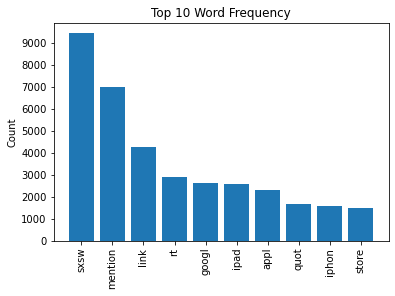

In [34]:
# Create a frequency distribution for X_train
df_freq_dist = FreqDist(df["tweet_stemmed"].explode())

# Plot the top 10 tokens
visualize_top_10(df_freq_dist, "Top 10 Word Frequency")

We saw that there continues to be stop words in our top 10 frequency distribution that need to be removed.

#### More Word Inspection and Removal 

We continue to look at the top frequent words and inspect their context, such as mention and link, to see if they don't serve us much purpose and need to be removed.

In [35]:
# Filter rows that contain 'sxsw' in 'tweet_stemmed' column
sxsw_filtered_df = df[df['tweet_stemmed'].apply(lambda x: 'sxsw' in x)]

# Set the column width option to display the full content
pd.set_option('display.max_colwidth', None)

# Print a sample of rows from the filtered dataframe
sxsw_sample_rows = sxsw_filtered_df['tweet_stemmed'].sample(n=10)  
print(sxsw_sample_rows)

2367                                            [offici, present, filmast, iphon, contest, world, best, mobil, app, sxsw, link]
8051                                                                       [ipad, sold, temporari, appl, store, congress, sxsw]
3437                                     [despit, sxsw, rumour, fli, around, yesterday, launch, googl, circl, plan, week, link]
4894                                [35, socialmedia, music, stori, may, miss, weekend, link, via, mention, sxsw, ipad2, iphon]
2951            [sxsw, mention, intrvw, mention, quot, govt, vend, machin, put, get, svc, platform, iphon, teach, moment, quot]
592     [futur, googl, contextu, discoveri, locat, context, help, us, go, deeper, ever, search, without, search, mention, sxsw]
1493                                   [hurrah, sxswi, festiv, begun, met, mozilla, googl, folk, tonight, mention, event, sxsw]
2468          [uber, brand, smart, gonna, move, ton, ipad2, appl, open, popup, shop, austin, sxsw, link,

In [36]:
#add sxsw to stop words
stopwords_list.append('sxsw')

In [37]:
# Filter rows that contain 'mention' in 'tweet_stemmed' column
mention_filtered_df = df[df['tweet_stemmed'].apply(lambda x: 'mention' in x)]

# Print a sample of rows from the filtered dataframe
mention_sample_rows = mention_filtered_df['tweet_stemmed'].sample(n=10)  
print(mention_sample_rows)

5849    [rt, mention, googl, marissa, mayer, futur, locat, augment, realiti, contextu, discoveri, make, smartphon, smarter, sxsw]
8242                           [sxsw, help, mention, charg, iphon, newtrent, imp1000, batteri, pack, love, thing, unpaid, endors]
2339                                             [sxsw, enchant, mention, quot, like, say, pleas, regist, go, googl, quot, hahah]
3153                          [kick, ipad, design, headach, josh, clark, mention, crowd, room, first, session, stand, room, sxsw]
6734                          [rt, mention, beluga, iphon, app, highlight, sxsw, excel, way, coordin, sxsw4japan, relief, effort]
1713                                                 [mention, sxsw, forget, mention, plan, schedul, plu, free, iphon, app, link]
8644                        [great, visualis, ghost, movement, logic, pacman, googl, doodl, session, mention, sxsw, detail, link]
7650     [anoth, great, panel, pm, hilton, austin, mention, nik, daftari, left, brain, sea

In [38]:
#add mention to stop words
stopwords_list.append('mention')

In [39]:
# Filter rows that contain 'link' in 'tweet_stemmed' column
link_filtered_df = df[df['tweet_stemmed'].apply(lambda x: 'link' in x)]

# Print a sample of rows from the filtered dataframe
link_sample_rows = link_filtered_df['tweet_stemmed'].sample(n=10)  
print(link_sample_rows)

608                                                                                     [post, noth, sxsw, link]
8186                      [thank, rt, mention, awesom, present, digit, magazin, link, touchingstori, sxsw, gsdm]
7503                                                 [mention, put, gun, mention, head, give, iphon, sxsw, link]
336                     [technew, sxsw, appl, school, market, expert, link, tech_new, appl, jobs_co, sxsw, tech]
2768    [awesom, rt, mention, knit, staircas, attend, sxsw, parti, tomo, 7pm, host, mention, amp, mention, link]
2170         [creatur, habit, googl, found, ctr, blue, link, far, outpac, green, darker, link, click, got, sxsw]
2355                    [mention, check, photo, feed, appl, store, sxsw, link, thank, mention, mention, mention]
750                                     [googl, launch, new, social, network, circl, possibl, today, link, sxsw]
3427                                                          [appl, pop, store, south, south, w

In [40]:
#add link to stop words
stopwords_list.append('link')

In [41]:
# Filter rows that contain 'rt' in 'tweet_stemmed' column
rt_filtered_df = df[df['tweet_stemmed'].apply(lambda x: 'rt' in x)]

# Print a sample of rows from the filtered dataframe
rt_sample_rows = rt_filtered_df['tweet_stemmed'].sample(n=10)  
print(rt_sample_rows)

8326                 [last, night, fun, rt, mention, chill, mention, mention, big, hair, station, mention, googl, parti, maggi, may, sxsw, link]
7769                                                 [awesom, rt, mention, head, austin, sxsw, austin, lp, guid, iphon, free, limit, time, link]
5770                                                           [rt, mention, get, look, sxsw, rumor, appl, quot, pop, quot, store, austin, link]
5747                                                                                      [rt, mention, free, jam, link, sxsw, mention, mention]
6529                                           [rt, mention, rt, mention, forward, delici, mobil, 4g, austin, iphon, user, struggl, anyth, sxsw]
6762                                                                         [rt, mention, news, sxswi, appl, temporari, ipad, store, sxsw, wth]
7324                  [droid, amp, mac, rt, mention, agnerd, confess, use, laptop, ipad, amp, blackberri, follow, sxsw, afar, see,

In [42]:
#add rt to stop words
stopwords_list.append('rt')

In [43]:
# Filter rows that contain 'quot' in 'tweet_stemmed' column
quot_filtered_df = df[df['tweet_stemmed'].apply(lambda x: 'quot' in x)]

# Print a sample of rows from the filtered dataframe
quot_sample_rows = quot_filtered_df['tweet_stemmed'].sample(n=10)  
print(quot_sample_rows)

3226         [best, thing, heard, long, actual, quot, gave, ipad, money, japan, relief, quot, sxsw, mention, mention, mention]
5065    [rt, mention, ûï, mention, appl, open, temporari, store, downtown, austin, sxsw, ipad, launch, quot, oh, yay, traffic]
7935      [sxsw, news, appl, get, music, busi, new, devic, call, quot, ipod, quot, like, compact, disc, player, without, disk]
4991                           [look, crowd, sxsw, everyon, head, look, ipad, phone, place, social, awkward, quot, cool, quot]
2875          [sxsw, panel, quot, stay, aliv, indi, iphon, game, develop, surviv, quot, kind, downer, tri, coronasdk, mention]
912                             [need, quot, page, flip, effect, quot, ûïlike, fake, needl, cd, player, tapworthi, sxsw, ipad]
5165                                              [rt, mention, quot, 40, googl, map, usag, mobil, quot, marissa, mayer, sxsw]
2588                                  [sxsw, waze, link, duke, googl, person, map, experi, friendli, quot, pane

In [44]:
#add quot to stop words
stopwords_list.append('quot')

Next we added a column to the dataframe that removes the additional stop words.

In [45]:
# Define a function to remove stopwords from text
def remove_stopwords(text):
    filtered_words = [word for word in text if word not in stopwords_list]
    return filtered_words

# Apply the remove_stopwords function to the 'tweet_stemmed' column and create a new column 'tweet_without_stopwords'
df['tweet_without_stopwords'] = df['tweet_stemmed'].apply(lambda x: remove_stopwords(x))


# Display the updated DataFrame
df.head()

,tweet,brand_or_product,sentiment,tweet_tokenized,tweet_stemmed,tweet_without_stopwords
0,".@wesley83 i have a 3g iphone. after 3 hrs tweeting at #rise_austin, it was dead! i need to upgrade. plugin stations at #sxsw.",iPhone,Negative,"[wesley83, 3g, iphone, hrs, tweeting, rise_austin, dead, need, upgrade, plugin, stations, sxsw]","[wesley83, 3g, iphon, hr, tweet, rise_austin, dead, need, upgrad, plugin, station, sxsw]","[wesley83, 3g, iphon, hr, tweet, rise_austin, dead, need, upgrad, plugin, station]"
1,"@jessedee know about @fludapp ? awesome ipad/iphone app that you'll likely appreciate for its design. also, they're giving free ts at #sxsw",iPad or iPhone App,Positive,"[jessedee, know, fludapp, awesome, ipad, iphone, app, likely, appreciate, design, also, giving, free, ts, sxsw]","[jessede, know, fludapp, awesom, ipad, iphon, app, like, appreci, design, also, give, free, ts, sxsw]","[jessede, know, fludapp, awesom, ipad, iphon, app, like, appreci, design, also, give, free, ts]"
2,@swonderlin can not wait for #ipad 2 also. they should sale them down at #sxsw.,iPad,Positive,"[swonderlin, wait, ipad, also, sale, sxsw]","[swonderlin, wait, ipad, also, sale, sxsw]","[swonderlin, wait, ipad, also, sale]"
3,@sxsw i hope this year's festival isn't as crashy as this year's iphone app. #sxsw,iPad or iPhone App,Negative,"[sxsw, hope, year, festival, crashy, year, iphone, app, sxsw]","[sxsw, hope, year, festiv, crashi, year, iphon, app, sxsw]","[hope, year, festiv, crashi, year, iphon, app]"
4,"@sxtxstate great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech books/conferences) &amp; matt mullenweg (wordpress)",Google,Positive,"[sxtxstate, great, stuff, fri, sxsw, marissa, mayer, google, tim, reilly, tech, books, conferences, amp, matt, mullenweg, wordpress]","[sxtxstate, great, stuff, fri, sxsw, marissa, mayer, googl, tim, reilli, tech, book, confer, amp, matt, mullenweg, wordpress]","[sxtxstate, great, stuff, fri, marissa, mayer, googl, tim, reilli, tech, book, confer, amp, matt, mullenweg, wordpress]"


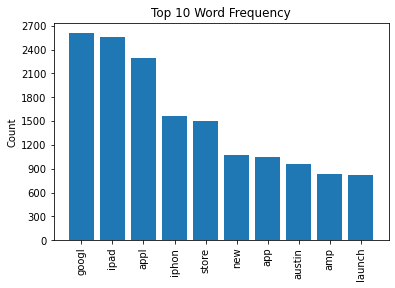

In [46]:
#update variable of cleaned text
tweet_words_stopped = [word for row in df['tweet_stemmed'] for word in row if word not in stopwords_list]

#create a frequency distribution of the updated stopped words list
tweet_stopped_freqdist = FreqDist(tweet_words_stopped)

# Plot the top 10 updated tokens
visualize_top_10(tweet_stopped_freqdist, "Top 10 Word Frequency")

Now that the most frequent words seem to better apply to the text of tweets that provide context, the next thing we do is visually inspect these words categorized by sentiment. 

In [47]:
#list of cleaned words from positive sentiment rows 
positive_tweet_words = [word for index, row in df.iterrows() if row['sentiment'] == 'Positive' for word in row['tweet_stemmed'] if word not in stopwords_list]

#create a frequency distribution of the positive words list
positive_tweet_freqdist = FreqDist(positive_tweet_words)

#list of cleaned words from negative sentiment rows 
negative_tweet_words = [word for index, row in df.iterrows() if row['sentiment'] == 'Negative' for word in row['tweet_stemmed'] if word not in stopwords_list]

#create a frequency distribution of the negative words list
negative_tweet_freqdist = FreqDist(negative_tweet_words)

#list of cleaned words from neutral sentiment rows 
neutral_tweet_words = [word for index, row in df.iterrows() if row['sentiment'] == 'Neutral' for word in row['tweet_stemmed'] if word not in stopwords_list]

#create a frequency distribution of the neutral words list
neutral_tweet_freqdist = FreqDist(neutral_tweet_words)

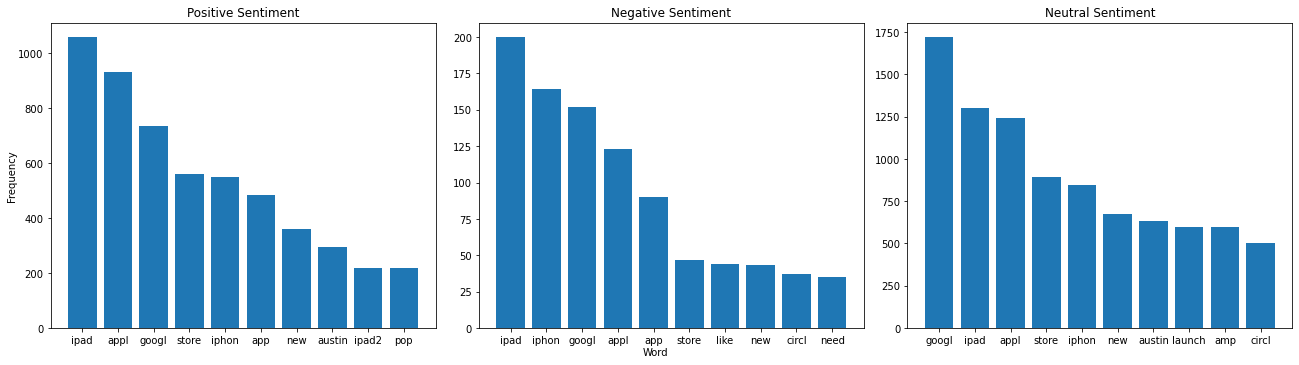

In [48]:
# Create subplots for the three graphs
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Plot the top 10 word frequency for positive sentiment
ax[0].bar(*zip(*positive_tweet_freqdist.most_common(10)))
ax[0].set_title('Positive Sentiment')

# Plot the top 10 word frequency for negative sentiment
ax[1].bar(*zip(*negative_tweet_freqdist.most_common(10)))
ax[1].set_title('Negative Sentiment')

# Plot the top 10 word frequency for neutral sentiment
ax[2].bar(*zip(*neutral_tweet_freqdist.most_common(10)))
ax[2].set_title('Neutral Sentiment')

# Set common x-label and y-label for all subplots
fig.text(0.5, 0.00, 'Word', ha='center')
fig.text(0.00, 0.5, 'Frequency', va='center', rotation='vertical')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

#### Remove Company Labels
As we can see in the graphs, there is a lot of crossover between the three different sentiments for 10 most frequent words, and most of them are of course the names of the brands and products. While the ipad2 seems to only appear in the positive sentiment as a member of the 10 most frequent, which could bet telling about that product, more inspection needs to be done. Next we removed names of the companies and broad products to see which new words would take their place in the graphs and if we would learn anything new. 

In [49]:
#create a list of brand names
brands_list = ['ipad', 'appl', 'googl', 'iphon', 'app']

#remove them from the existing lists 
brandless_positive_tweet_words = [word for word in positive_tweet_words if word not in brands_list]
brandless_negative_tweet_words = [word for word in negative_tweet_words if word not in brands_list]
brandless_neutral_tweet_words = [word for word in neutral_tweet_words if word not in brands_list]

#update the FreqDist action 
brandless_positive_tweet_freqdist = FreqDist(brandless_positive_tweet_words)
brandless_negative_tweet_freqdist = FreqDist(brandless_negative_tweet_words)
brandless_neutral_tweet_freqdist = FreqDist(brandless_neutral_tweet_words)

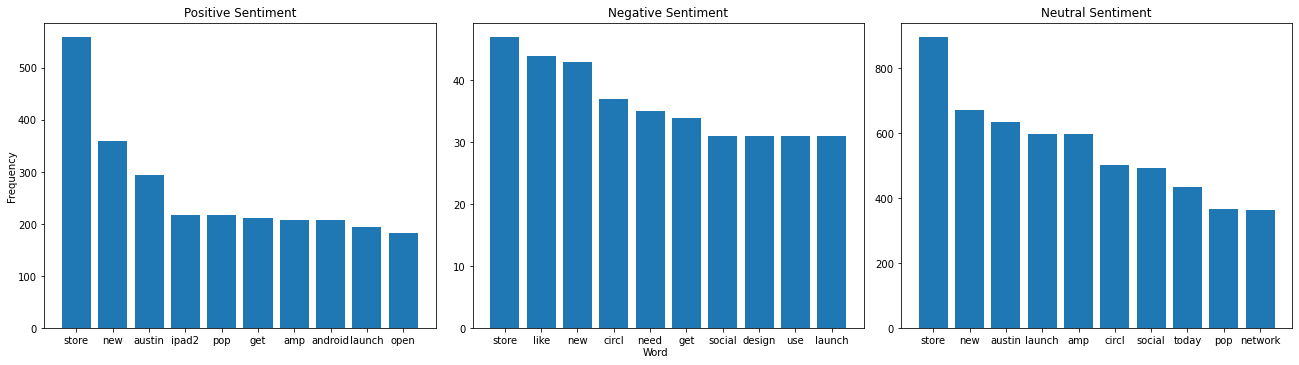

In [50]:
# Create subplots for the three graphs
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Plot the top 10 word frequency for positive sentiment
ax[0].bar(*zip(*brandless_positive_tweet_freqdist.most_common(10)))
ax[0].set_title('Positive Sentiment')

# Plot the top 10 word frequency for negative sentiment
ax[1].bar(*zip(*brandless_negative_tweet_freqdist.most_common(10)))
ax[1].set_title('Negative Sentiment')

# Plot the top 10 word frequency for neutral sentiment
ax[2].bar(*zip(*brandless_neutral_tweet_freqdist.most_common(10)))
ax[2].set_title('Neutral Sentiment')

# Set common x-label and y-label for all subplots
fig.text(0.5, 0.00, 'Word', ha='center')
fig.text(0.00, 0.5, 'Frequency', va='center', rotation='vertical')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

We're starting to see a little bit more information. For instance, ipad2 remains a likely indicator of a positive sentiment, while the word "need" seems to indicate the tweet is more likely to be negative. Interestingly, mention of the android also seems to more likely indicate a positive tweet. 

#### Add Column Without Brand Names 

In [51]:
# Define a function to remove brands from text
def remove_brands(text):
    filtered_words = [word for word in text if word not in brands_list]
    return filtered_words

# Apply the remove_brands function to the 'tweet_without_stopwords' column and create a new column 'brandless_tweet_without_stopwords'
df['brandless_tweet_without_stopwords'] = df['tweet_without_stopwords'].apply(lambda x: remove_brands(x))

# Display the updated DataFrame
df.head()

,tweet,brand_or_product,sentiment,tweet_tokenized,tweet_stemmed,tweet_without_stopwords,brandless_tweet_without_stopwords
0,".@wesley83 i have a 3g iphone. after 3 hrs tweeting at #rise_austin, it was dead! i need to upgrade. plugin stations at #sxsw.",iPhone,Negative,"[wesley83, 3g, iphone, hrs, tweeting, rise_austin, dead, need, upgrade, plugin, stations, sxsw]","[wesley83, 3g, iphon, hr, tweet, rise_austin, dead, need, upgrad, plugin, station, sxsw]","[wesley83, 3g, iphon, hr, tweet, rise_austin, dead, need, upgrad, plugin, station]","[wesley83, 3g, hr, tweet, rise_austin, dead, need, upgrad, plugin, station]"
1,"@jessedee know about @fludapp ? awesome ipad/iphone app that you'll likely appreciate for its design. also, they're giving free ts at #sxsw",iPad or iPhone App,Positive,"[jessedee, know, fludapp, awesome, ipad, iphone, app, likely, appreciate, design, also, giving, free, ts, sxsw]","[jessede, know, fludapp, awesom, ipad, iphon, app, like, appreci, design, also, give, free, ts, sxsw]","[jessede, know, fludapp, awesom, ipad, iphon, app, like, appreci, design, also, give, free, ts]","[jessede, know, fludapp, awesom, like, appreci, design, also, give, free, ts]"
2,@swonderlin can not wait for #ipad 2 also. they should sale them down at #sxsw.,iPad,Positive,"[swonderlin, wait, ipad, also, sale, sxsw]","[swonderlin, wait, ipad, also, sale, sxsw]","[swonderlin, wait, ipad, also, sale]","[swonderlin, wait, also, sale]"
3,@sxsw i hope this year's festival isn't as crashy as this year's iphone app. #sxsw,iPad or iPhone App,Negative,"[sxsw, hope, year, festival, crashy, year, iphone, app, sxsw]","[sxsw, hope, year, festiv, crashi, year, iphon, app, sxsw]","[hope, year, festiv, crashi, year, iphon, app]","[hope, year, festiv, crashi, year]"
4,"@sxtxstate great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech books/conferences) &amp; matt mullenweg (wordpress)",Google,Positive,"[sxtxstate, great, stuff, fri, sxsw, marissa, mayer, google, tim, reilly, tech, books, conferences, amp, matt, mullenweg, wordpress]","[sxtxstate, great, stuff, fri, sxsw, marissa, mayer, googl, tim, reilli, tech, book, confer, amp, matt, mullenweg, wordpress]","[sxtxstate, great, stuff, fri, marissa, mayer, googl, tim, reilli, tech, book, confer, amp, matt, mullenweg, wordpress]","[sxtxstate, great, stuff, fri, marissa, mayer, tim, reilli, tech, book, confer, amp, matt, mullenweg, wordpress]"


#### Word Cloud

We created a word cloud for each of the 3 sentiment categories, a common display of words and their frequency.

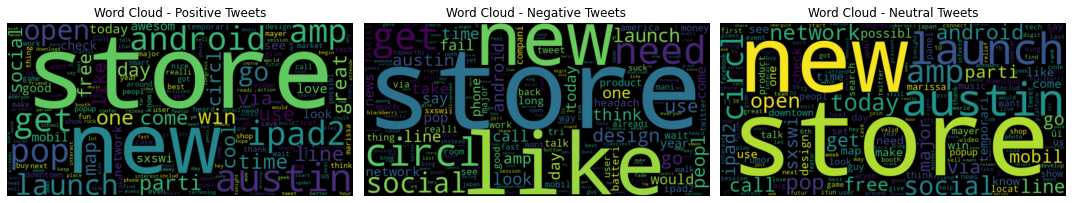

In [52]:
# Count the frequency of each word for each sentiment
positive_word_counts = Counter(brandless_positive_tweet_words)
negative_word_counts = Counter(brandless_negative_tweet_words)
neutral_word_counts = Counter(brandless_neutral_tweet_words)

# Generate the word cloud
positive_wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(positive_word_counts)
negative_wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(negative_word_counts)
neutral_wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(neutral_word_counts)

# Create a figure and axes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display the word clouds with titles
axes[0].imshow(positive_wordcloud, interpolation='bilinear')
axes[0].set_title('Word Cloud - Positive Tweets')
axes[0].axis('off')

axes[1].imshow(negative_wordcloud, interpolation='bilinear')
axes[1].set_title('Word Cloud - Negative Tweets')
axes[1].axis('off')

axes[2].imshow(neutral_wordcloud, interpolation='bilinear')
axes[2].set_title('Word Cloud - Neutral Tweets')
axes[2].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

We are seeing more information now. The words "new" and "store" seem to be common across the board, but "launch" is much more common in neutral tweets, "austin" is most common in positive tweets, and "like" is very common in negative tweets, which is difficult to interpret without more context, but you can also see some more indicative words like "headach", which is clearly our stemmed version of the word "headache". The presence of this word is a strong indicator that the tweet is negative. 

#### Bigrams 

Next we created bigrams to get a bit more context of the top words for each sentiment. 

In [53]:
#create bigrams for each sentiment
positive_bigrams = list(ngrams(positive_tweet_words, 2))
negative_bigrams = list(ngrams(negative_tweet_words, 2))
neutral_bigrams = list(ngrams(neutral_tweet_words, 2))

#measure the frequency
positive_bigram_freq = Counter(positive_bigrams)
negative_bigram_freq = Counter(negative_bigrams)
neutral_bigram_freq = Counter(neutral_bigrams)

#order them in frequency
most_common_positive_bigrams = positive_bigram_freq.most_common()
most_common_negative_bigrams = negative_bigram_freq.most_common()
most_common_neutral_bigrams = neutral_bigram_freq.most_common()

#get the sum and normalize the frequency
total_positive_bigrams = sum(positive_bigram_freq.values())
total_negative_bigrams = sum(negative_bigram_freq.values())
total_neutral_bigrams = sum(neutral_bigram_freq.values())

normalized_positive_bigrams = [(bigram, freq / total_positive_bigrams * 100) for bigram, freq in most_common_positive_bigrams]
normalized_negative_bigrams = [(bigram, freq / total_negative_bigrams * 100) for bigram, freq in most_common_negative_bigrams]
normalized_neutral_bigrams = [(bigram, freq / total_neutral_bigrams * 100) for bigram, freq in most_common_neutral_bigrams]


#print first 15 rows of each 
print("Top 15 Bigrams With a Positive Sentiment: ", normalized_positive_bigrams[:15], "\n")
print("Top 15 Bigrams With a Negative Sentiment: ", normalized_negative_bigrams[:15], "\n")
print("Top 15 Bigrams With a Neutral Sentiment: ", normalized_neutral_bigrams[:15], "\n")

Top 15 Bigrams With a Positive Sentiment:  [(('appl', 'store'), 0.7869609317617432), (('iphon', 'app'), 0.5526214543038019), (('pop', 'store'), 0.4826693714805358), (('appl', 'open'), 0.3917316638102899), (('social', 'network'), 0.30079395614004406), (('googl', 'map'), 0.30079395614004406), (('appl', 'pop'), 0.29729635199888077), (('ipad', 'app'), 0.2937987478577175), (('new', 'social'), 0.26931551886957433), (('downtown', 'austin'), 0.2518274981637578), (('store', 'downtown'), 0.24483228988143121), (('googl', 'launch'), 0.24483228988143121), (('temporari', 'store'), 0.23433947745794131), (('new', 'ipad'), 0.22734426917561473), (('marissa', 'mayer'), 0.2028610401874716)] 

Top 15 Bigrams With a Negative Sentiment:  [(('iphon', 'app'), 0.4423213021939137), (('appl', 'store'), 0.4423213021939137), (('ipad', 'design'), 0.3538570417551309), (('design', 'headach'), 0.30077848549186126), (('googl', 'circl'), 0.28308563340410475), (('new', 'social'), 0.28308563340410475), (('googl', 'launch')

Some of the distinct pairings include tweets about downtown Austin where the convention took place in the positive sentiment camp, while tweets about ipad designs are in the negative sentiment camp.

#### Visualize Sentiment by Brand/Product 

In this sub-section, we plotted graphs to inspect the breakdown of tweets' sentiment by each value in our brand_or_product column. 

In [54]:
#create a df that groups by brand_or_product values
brand_or_product_df = df.groupby(['brand_or_product', 'sentiment'])

In [55]:
#calculate the count of each sentiment value
count_df = brand_or_product_df.size().unstack()
count_df

sentiment,Negative,Neutral,Positive
brand_or_product,,,
Android,10,193,83
Android App,8,1,71
Apple,99,662,567
Google,86,1544,436
Other Apple product or service,2,1,32
Other Google product or service,47,9,236
Unknown,5,1428,59
iPad,136,895,856
iPad or iPhone App,63,10,396


In [56]:
#convert to percentages
percentage_df = count_df.div(count_df.sum(axis=1), axis=0) * 100
percentage_df

sentiment,Negative,Neutral,Positive
brand_or_product,,,
Android,3.496503,67.482517,29.020979
Android App,10.000000,1.250000,88.750000
Apple,7.454819,49.849398,42.695783
Google,4.162633,74.733785,21.103582
Other Apple product or service,5.714286,2.857143,91.428571
Other Google product or service,16.095890,3.082192,80.821918
Unknown,0.335121,95.710456,3.954424
iPad,7.207207,47.429783,45.363010
iPad or iPhone App,13.432836,2.132196,84.434968


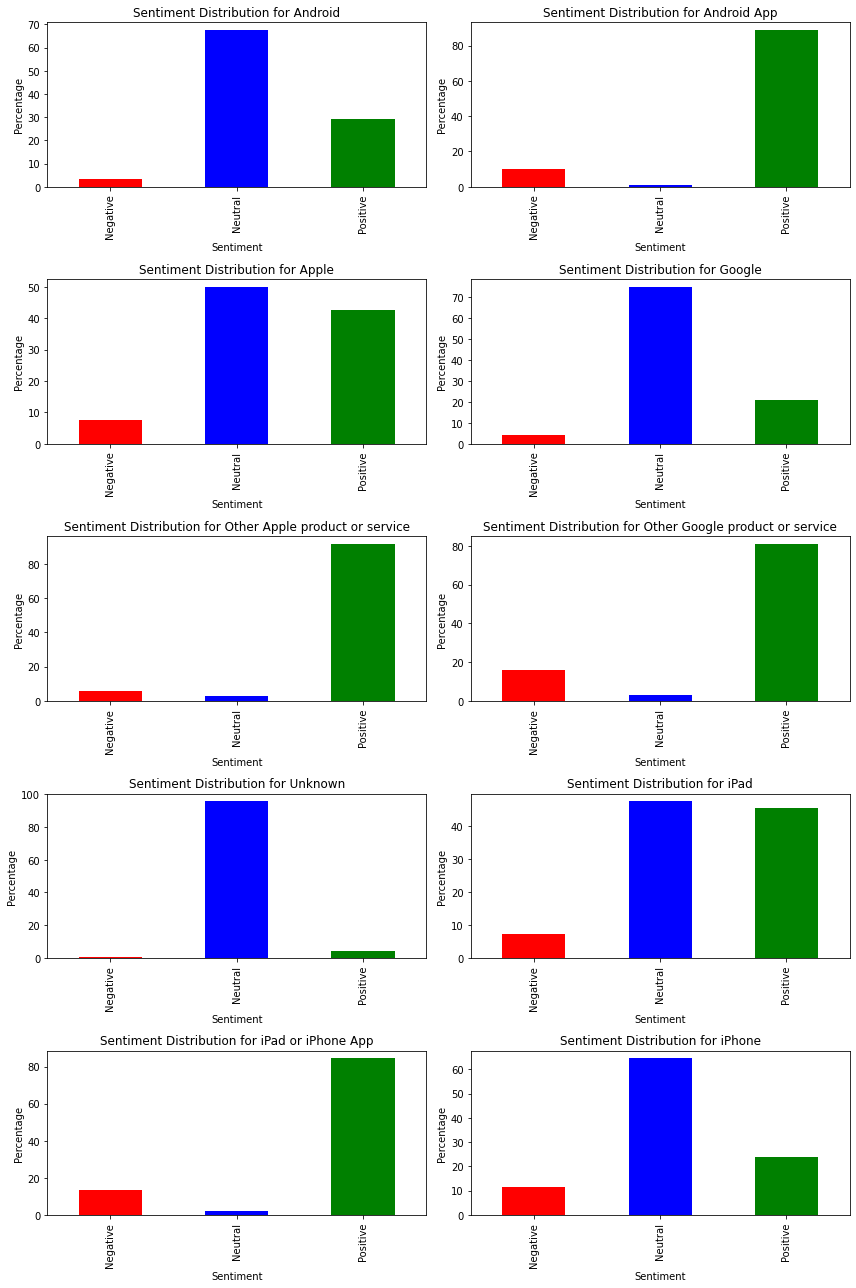

In [57]:
# Calculate the number of rows and columns for the subplots
nrows = (len(percentage_df) + 1) // 2
ncols = 2

# Define colors for each sentiment value
colors = {'Positive': 'green', 'Negative': 'red', 'Neutral': 'blue'}

# Create a grid of subplots with adjusted size
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 18))

# Flatten the axes array to iterate over it
axes = axes.flatten()

# Loop over each brand and plot the bar graph on a separate subplot
for i, brand in enumerate(percentage_df.index):
    percentages = percentage_df.loc[brand]
    percentages.plot.bar(ax=axes[i], color=[colors.get(sentiment, 'gray') for sentiment in percentages.index])
    axes[i].set_title(f"Sentiment Distribution for {brand}")
    axes[i].set_xlabel("Sentiment")
    axes[i].set_ylabel("Percentage")

# Remove any extra subplots
if len(percentage_df) < nrows * ncols:
    for j in range(len(percentage_df), nrows * ncols):
        fig.delaxes(axes[j])

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

Upon inspecting these graphs, while it's less likely to come across a negative tweet than a positive/neutral tweet for all brands and products, it would appear that tweets directed at the iPhone are the most contentious. Tweets about Google in general and the Android are not overwhelmingly positive either.

In [58]:
df.head()

,tweet,brand_or_product,sentiment,tweet_tokenized,tweet_stemmed,tweet_without_stopwords,brandless_tweet_without_stopwords
0,".@wesley83 i have a 3g iphone. after 3 hrs tweeting at #rise_austin, it was dead! i need to upgrade. plugin stations at #sxsw.",iPhone,Negative,"[wesley83, 3g, iphone, hrs, tweeting, rise_austin, dead, need, upgrade, plugin, stations, sxsw]","[wesley83, 3g, iphon, hr, tweet, rise_austin, dead, need, upgrad, plugin, station, sxsw]","[wesley83, 3g, iphon, hr, tweet, rise_austin, dead, need, upgrad, plugin, station]","[wesley83, 3g, hr, tweet, rise_austin, dead, need, upgrad, plugin, station]"
1,"@jessedee know about @fludapp ? awesome ipad/iphone app that you'll likely appreciate for its design. also, they're giving free ts at #sxsw",iPad or iPhone App,Positive,"[jessedee, know, fludapp, awesome, ipad, iphone, app, likely, appreciate, design, also, giving, free, ts, sxsw]","[jessede, know, fludapp, awesom, ipad, iphon, app, like, appreci, design, also, give, free, ts, sxsw]","[jessede, know, fludapp, awesom, ipad, iphon, app, like, appreci, design, also, give, free, ts]","[jessede, know, fludapp, awesom, like, appreci, design, also, give, free, ts]"
2,@swonderlin can not wait for #ipad 2 also. they should sale them down at #sxsw.,iPad,Positive,"[swonderlin, wait, ipad, also, sale, sxsw]","[swonderlin, wait, ipad, also, sale, sxsw]","[swonderlin, wait, ipad, also, sale]","[swonderlin, wait, also, sale]"
3,@sxsw i hope this year's festival isn't as crashy as this year's iphone app. #sxsw,iPad or iPhone App,Negative,"[sxsw, hope, year, festival, crashy, year, iphone, app, sxsw]","[sxsw, hope, year, festiv, crashi, year, iphon, app, sxsw]","[hope, year, festiv, crashi, year, iphon, app]","[hope, year, festiv, crashi, year]"
4,"@sxtxstate great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech books/conferences) &amp; matt mullenweg (wordpress)",Google,Positive,"[sxtxstate, great, stuff, fri, sxsw, marissa, mayer, google, tim, reilly, tech, books, conferences, amp, matt, mullenweg, wordpress]","[sxtxstate, great, stuff, fri, sxsw, marissa, mayer, googl, tim, reilli, tech, book, confer, amp, matt, mullenweg, wordpress]","[sxtxstate, great, stuff, fri, marissa, mayer, googl, tim, reilli, tech, book, confer, amp, matt, mullenweg, wordpress]","[sxtxstate, great, stuff, fri, marissa, mayer, tim, reilli, tech, book, confer, amp, matt, mullenweg, wordpress]"


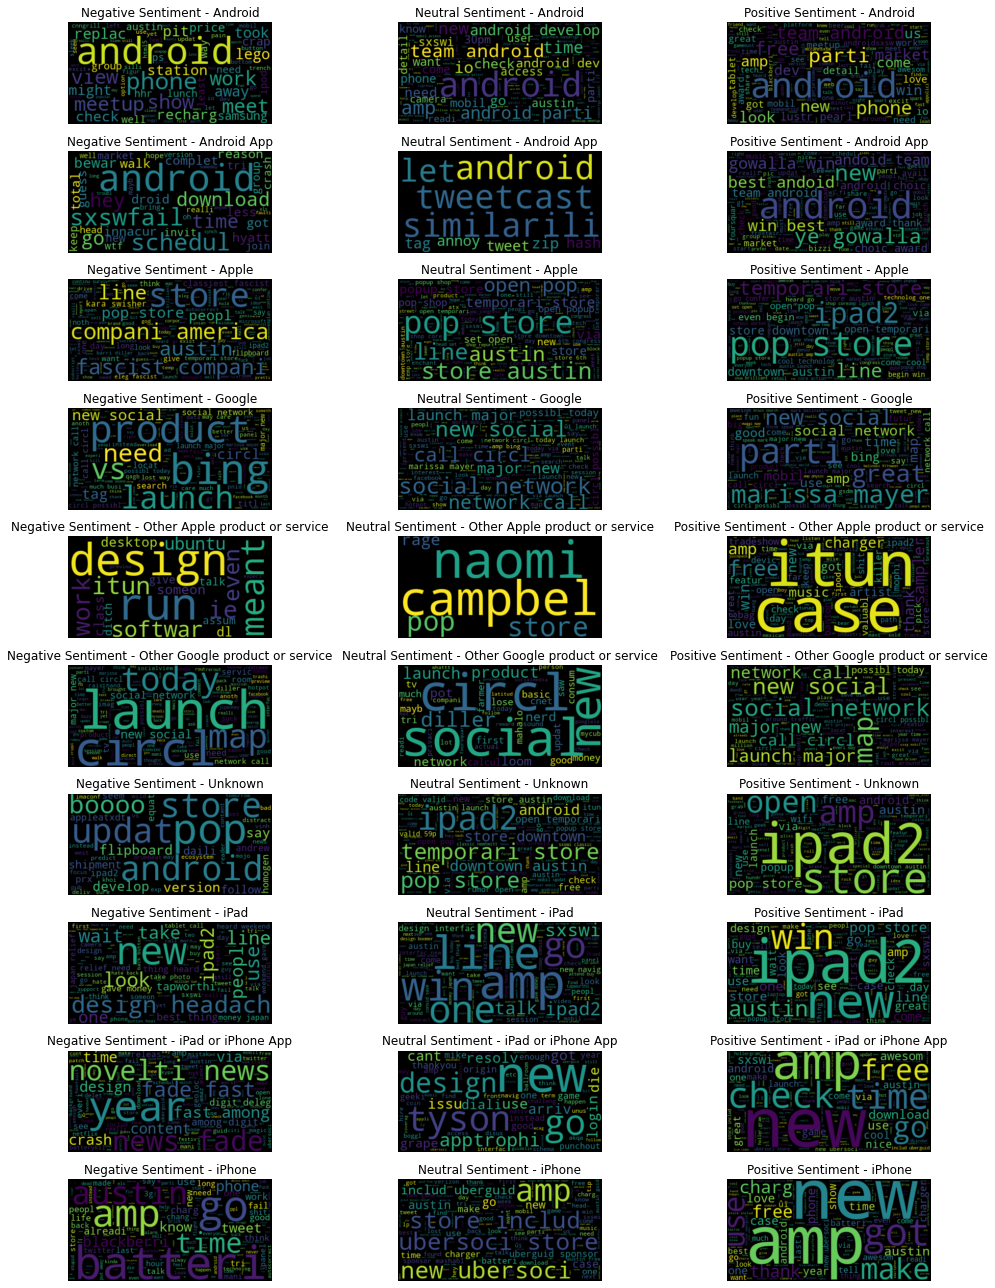

In [59]:
# Calculate the number of rows and columns for the subplots
nrows = len(percentage_df)
ncols = len(percentage_df.columns)

# Create a grid of subplots with adjusted size
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 18))

# Loop over each brand and sentiment
for i, brand in enumerate(percentage_df.index):
    for j, sentiment in enumerate(percentage_df.columns):
        # Filter the data for the specific brand and sentiment
        filtered_data = df[(df['brand_or_product'] == brand) & (df['sentiment'] == sentiment)]

        # Concatenate all the text data
        text = ' '.join(filtered_data['brandless_tweet_without_stopwords'].explode().fillna(''))

        # Generate the word cloud
        wordcloud = WordCloud().generate(text)

        # Plot the word cloud on the corresponding subplot
        axes[i, j].imshow(wordcloud, interpolation='bilinear')
        axes[i, j].set_title(f"{sentiment} Sentiment - {brand}")
        axes[i, j].axis('off')

# Remove any extra subplots
if len(percentage_df) < nrows * ncols:
    for i in range(len(percentage_df), nrows):
        for j in range(ncols):
            fig.delaxes(axes[i, j])

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

This provides a lot more insight into keywords that arise for each product by sentiment.

## Model